# Uber Request Data — Exploratory Data Analysis (EDA)

## Overview
Understanding and analyzing the **temporal** and **location-based** distributions of Uber ride requests is a critical issue that has wide-ranging
implications for customer satisfaction, platform revenue, driver utilization, and operational efficiency. It is important to recognize that data
analysis in this context is not just a technical exercise but a way to identify bottlenecks and guide decisions that affect real users (riders and drivers).

This project uses EDA as a **problem-solving tool**: we quantify how often requests fail, identify *when* failures occur, compare *where* failures occur
(City vs Airport), and map recurring hotspots so that operational interventions can be targeted.

### Why this analysis matters (problem-solving motivation)
- **Enhancing reliability and customer trust:** Measuring Completed vs Cancelled vs No Cars Available helps quantify platform reliability and highlights the dominant failure mode.
- **Promoting efficient resource allocation:** Identifying peak gap hours supports smarter driver scheduling, incentive placement, and surge pricing decisions.
- **Improving location-based operations:** Comparing City vs Airport reveals whether certain pickup points need special dispatch strategies (e.g., airport staging/queue management).
- **Reducing cancellations:** Understanding when and where cancellations rise can guide interventions that reduce waiting time and matching friction.

## Analysis Overview
We will:
1. Inspect data quality (shape, columns, missing values) and parse timestamps robustly.
2. Engineer time features (hour, weekday, date) and define an unmet-demand indicator.
3. Ask and answer **four research questions** using descriptive statistics and **four visualizations**.
4. Summarize insights and propose actions to reduce unmet demand.

**Dataset:** `Uber Request Data.csv`


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Uber Request Data.csv")
df.head()


,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


## 1) Data understanding and quality checks
We inspect the dataset shape/columns and check missing values. Missing values are interpreted in the business context (not automatically imputed).


In [2]:
df.shape, df.columns.tolist()

((6745, 6),
 ['Request id',
  'Pickup point',
  'Driver id',
  'Status',
  'Request timestamp',
  'Drop timestamp'])

In [3]:
df.isna().sum()

,0
Request id,0
Pickup point,0
Driver id,2650
Status,0
Request timestamp,0
Drop timestamp,3914


## 2) Timestamp parsing and feature engineering
The timestamp columns contain mixed formats. We parse them robustly and create time features (hour, weekday, date) and outcome indicators.


In [4]:
def robust_parse_datetime(s: pd.Series) -> pd.Series:
    dt1 = pd.to_datetime(s, errors="coerce", dayfirst=True)
    mask = dt1.isna()
    if mask.any():
        dt2 = pd.to_datetime(s[mask], errors="coerce", dayfirst=False)
        dt1.loc[mask] = dt2
    return dt1

df["request_dt"] = robust_parse_datetime(df["Request timestamp"])
df["drop_dt"] = robust_parse_datetime(df["Drop timestamp"])

df["request_date"] = df["request_dt"].dt.date
df["request_hour"] = df["request_dt"].dt.hour
df["weekday"] = df["request_dt"].dt.day_name()

df["is_completed"] = (df["Status"] == "Trip Completed").astype(int)
df["is_cancelled"] = (df["Status"] == "Cancelled").astype(int)
df["is_no_cars"] = (df["Status"] == "No Cars Available").astype(int)
df["is_unmet"] = (df["Status"] != "Trip Completed").astype(int)

df[["Request id","Pickup point","Driver id","Status","request_dt","drop_dt"]].head()


/tmp/ipython-input-1696555001.py:5: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dt2 = pd.to_datetime(s[mask], errors="coerce", dayfirst=False)
/tmp/ipython-input-1696555001.py:5: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dt2 = pd.to_datetime(s[mask], errors="coerce", dayfirst=False)


,Request id,Pickup point,Driver id,Status,request_dt,drop_dt
0,619,Airport,1.0,Trip Completed,2016-07-11 11:51:00,2016-07-11 13:00:00
1,867,Airport,1.0,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00
2,1807,City,1.0,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00
3,2532,Airport,1.0,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47


### Interpreting missing values
- `Driver id` is missing when a driver was never assigned (commonly for **No Cars Available**).  
- `Drop timestamp` is missing when a trip did not happen (Cancelled/No Cars).  

These missing values are expected and meaningful, so we keep them.


## Q1) What proportion of requests were completed vs unmet?

**Why this matters:** This measures service reliability and quantifies the size of the operational problem.


In [5]:
status_counts = df["Status"].value_counts()
status_pct = (status_counts / len(df) * 100).round(2)
status_counts, status_pct

(Status
 Trip Completed       2831
 No Cars Available    2650
 Cancelled            1264
 Name: count, dtype: int64,
 Status
 Trip Completed       41.97
 No Cars Available    39.29
 Cancelled            18.74
 Name: count, dtype: float64)

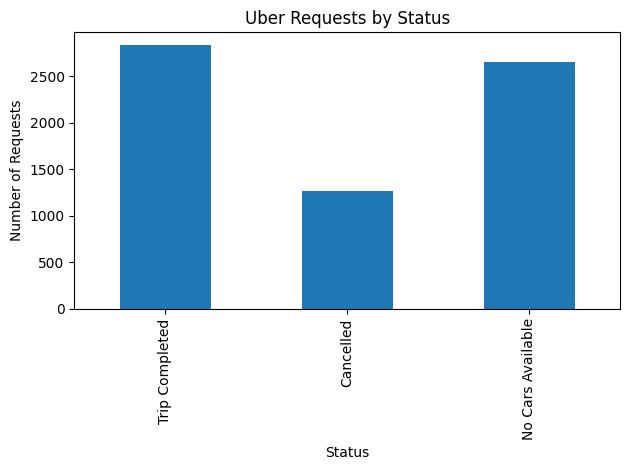

In [6]:
plt.figure()
status_counts.loc[["Trip Completed","Cancelled","No Cars Available"]].plot(kind="bar")
plt.title("Uber Requests by Status")
plt.xlabel("Status")
plt.ylabel("Number of Requests")
plt.tight_layout()
plt.show()


## Q2) When is the supply–demand gap highest?

We define:
- Demand = number of requests  
- Supply = number of completed trips  
- Gap = Demand − Supply  

**Why this matters:** Peak gap hours are where additional drivers/incentives have the biggest impact.


In [7]:
hourly = df.groupby("request_hour").agg(
    requests=("Request id","count"),
    completed=("is_completed","sum")
).reset_index()
hourly["gap"] = hourly["requests"] - hourly["completed"]
hourly.head()

,request_hour,requests,completed,gap
0,0,99,40,59
1,1,85,25,60
2,2,99,37,62
3,3,92,34,58
4,4,203,78,125


In [8]:
peak_gap_hour = int(hourly.loc[hourly["gap"].idxmax(), "request_hour"])
peak_gap_value = int(hourly["gap"].max())
peak_gap_hour, peak_gap_value

(18, 346)

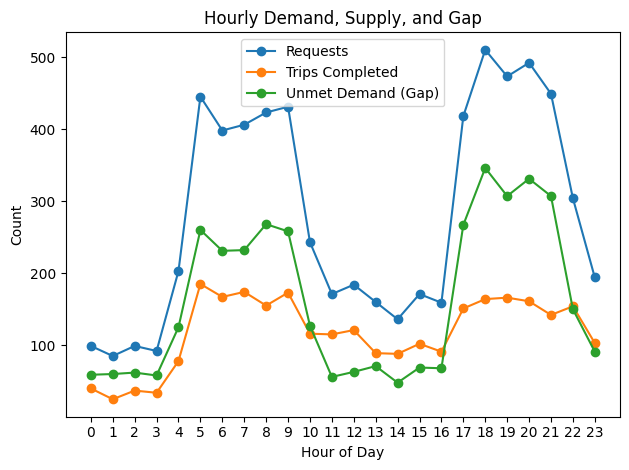

In [9]:
plt.figure()
plt.plot(hourly["request_hour"], hourly["requests"], marker="o", label="Requests")
plt.plot(hourly["request_hour"], hourly["completed"], marker="o", label="Trips Completed")
plt.plot(hourly["request_hour"], hourly["gap"], marker="o", label="Unmet Demand (Gap)")
plt.title("Hourly Demand, Supply, and Gap")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.xticks(range(0,24))
plt.legend()
plt.tight_layout()
plt.show()


## Q3) Does pickup point (City vs Airport) affect unmet-demand rates?

**Why this matters:** Location-based differences suggest targeted operational strategies (e.g., airport staging/incentives).


In [10]:
by_pickup = df.groupby("Pickup point").agg(
    requests=("Request id","count"),
    completed=("is_completed","sum"),
    cancelled=("is_cancelled","sum"),
    no_cars=("is_no_cars","sum")
)

by_pickup["completion_rate_pct"] = (by_pickup["completed"]/by_pickup["requests"]*100).round(2)
by_pickup["cancel_rate_pct"] = (by_pickup["cancelled"]/by_pickup["requests"]*100).round(2)
by_pickup["no_cars_rate_pct"] = (by_pickup["no_cars"]/by_pickup["requests"]*100).round(2)
by_pickup

,requests,completed,cancelled,no_cars,completion_rate_pct,cancel_rate_pct,no_cars_rate_pct
Pickup point,,,,,,,
Airport,3238,1327,198,1713,40.98,6.11,52.90
City,3507,1504,1066,937,42.89,30.40,26.72


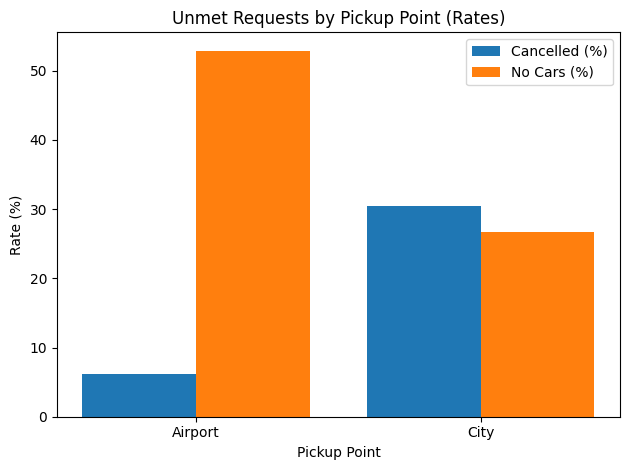

In [11]:
plt.figure()
x = np.arange(len(by_pickup.index))
plt.bar(x - 0.2, by_pickup["cancel_rate_pct"], width=0.4, label="Cancelled (%)")
plt.bar(x + 0.2, by_pickup["no_cars_rate_pct"], width=0.4, label="No Cars (%)")
plt.title("Unmet Requests by Pickup Point (Rates)")
plt.xlabel("Pickup Point")
plt.ylabel("Rate (%)")
plt.xticks(x, by_pickup.index)
plt.legend()
plt.tight_layout()
plt.show()


## Q4) What are the recurring weekday×hour hotspots for unmet demand?

**Why this matters:** Hotspots are predictable. Uber can schedule driver supply/incentives proactively rather than reacting in real time.


In [12]:
daily = df.groupby("request_date").agg(
    requests=("Request id","count"),
    completed=("is_completed","sum")
).reset_index()
daily["gap"] = daily["requests"] - daily["completed"]

peak_gap_day = str(daily.loc[daily["gap"].idxmax(), "request_date"])
peak_gap_day_value = int(daily["gap"].max())
peak_gap_day, peak_gap_day_value

('2016-07-14', 823)

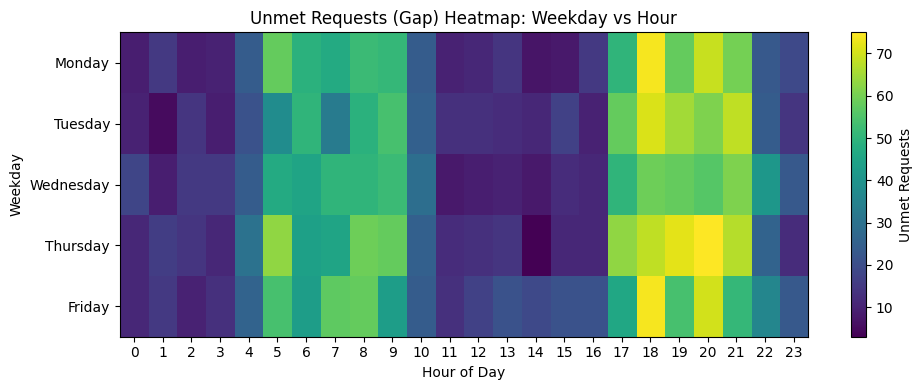

In [13]:
pivot = df.pivot_table(index="weekday", columns="request_hour", values="is_unmet", aggfunc="sum", fill_value=0)
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
pivot = pivot.reindex([w for w in weekday_order if w in pivot.index])

plt.figure(figsize=(10,4))
plt.imshow(pivot.values, aspect="auto")
plt.title("Unmet Requests (Gap) Heatmap: Weekday vs Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Weekday")
plt.xticks(ticks=np.arange(0,24), labels=np.arange(0,24))
plt.yticks(ticks=np.arange(len(pivot.index)), labels=pivot.index)
plt.colorbar(label="Unmet Requests")
plt.tight_layout()
plt.show()


## Recommendations
1. **Targeted driver incentives/surge pricing** during peak-gap hours and hotspot windows.  
2. **Airport staging / queue management** if the airport exhibits higher unmet demand (especially "No Cars").  
3. **Cancellation reduction**: investigate wait time and matching performance during hotspot periods.  
4. **Monitoring**: track status share, hourly gap, and hotspot heatmap weekly to evaluate whether interventions reduce unmet demand.
